# Decision Tree Classifier

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

A **decision tree** is a type of supervised machine learning used to categorize or make predictions based on how a previous set of questions were answered. The model is a form of supervised learning, meaning that the model is trained and tested on a set of data that contains the desired categorization.

**Information gain** is the basic criterion to decide whether a feature should be used to split a node or not. Basically we choose the feature which makes more **information gain**.

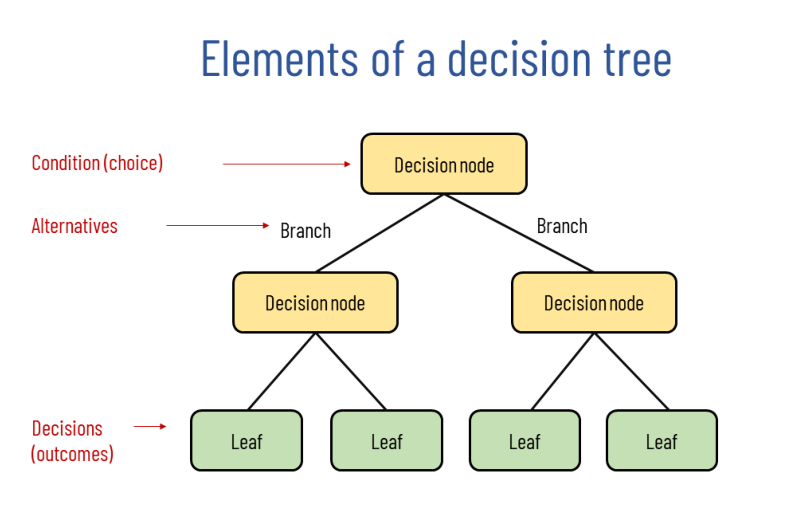

In [4]:
display_img('Elements.webp', 10, 10)

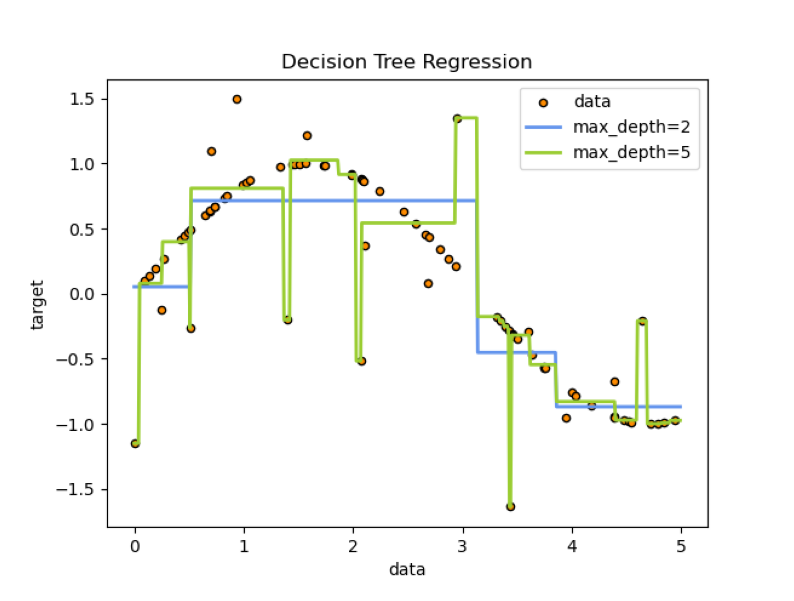

In [5]:
display_img('Decision_Tree.png', 10, 10)

**Considerations:**

- The trees aren't sensitive to scaling.

In [6]:
start = time.time()

# 1. Preprocessing

### i. Read Dataframe

In [7]:
df = pd.read_csv('credit_risk.csv')

In [8]:
cat_str = ['person_home_ownership', 'loan_intent']
cat_oh = ['cb_person_default_on_file', 'loan_grade']

num_mean = ['person_age', 'person_income', 'loan_percent_income']

num_mean_nan = ['loan_int_rate', 'person_emp_length']
num_zero_nan = ['loan_amnt']

X_cols = cat_str + cat_oh + num_mean + num_mean_nan + num_zero_nan

label = 'loan_status'

### ii. Drop 'y' NaNs

In [9]:
df = df[df[label].notna()]

### iii. Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
features_dict = {
    'cat_str': cat_str,
    'cat_oh': cat_oh,
    'num_mean': num_mean,
    'num_mean_nan': num_mean_nan,
    'num_zero_nan': num_zero_nan
}

In [12]:
X = df[X_cols].copy()
y = df[label].copy()

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.40, random_state = 10)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.50, random_state = 10)

### iv. Fit preprocess

In [14]:
from preprocessing import *

In [15]:
transformers_pre = get_fit_transfomers(features_dict, X_train, y_train)

In [16]:
y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

y_val = y_val.reset_index()
y_val = y_val.drop(columns = ['index'])

y_test = y_test.reset_index()
y_test = y_test.drop(columns = ['index'])

In [17]:
X_train = transform_datasets(transformers_pre, features_dict, X_train)

X_val = transform_datasets(transformers_pre, features_dict, X_val)

X_test = transform_datasets(transformers_pre, features_dict, X_test)

### v. Train model (with Fine Tunning)

In [18]:
from sklearn.metrics import f1_score

In [19]:
from sklearn.tree import DecisionTreeClassifier

In [20]:
M_depth_max = 10

In [21]:
M_depth = [j for j in range(1, M_depth_max + 1)]

In [22]:
threshold = round(y_val['loan_status'].mean(), 2)

In [23]:
all_f1_train = []
all_f1_val = []
all_params = []    

for m_depth in M_depth:

    print('Max Depth: ', m_depth)

    clf = DecisionTreeClassifier(max_depth = m_depth, random_state = 0)

    clf = clf.fit(X_train, y_train)

    y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
    y_val_pred_prob = clf.predict_proba(X_val)[:, 1]

    y_train_pred = (y_train_pred_prob >= threshold)*1
    y_val_pred = (y_val_pred_prob >= threshold)*1

    f1_train = f1_score(y_train, y_train_pred)
    f1_val = f1_score(y_val, y_val_pred)

    all_f1_train.append(f1_train)
    all_f1_val.append(f1_val)
    all_params.append([m_depth])
    
    print('-'*70)

all_f1_train = np.array(all_f1_train)
all_f1_val = np.array(all_f1_val)
all_params = np.array(all_params)

Max Depth:  1
----------------------------------------------------------------------
Max Depth:  2
----------------------------------------------------------------------
Max Depth:  3
----------------------------------------------------------------------
Max Depth:  4
----------------------------------------------------------------------
Max Depth:  5
----------------------------------------------------------------------
Max Depth:  6
----------------------------------------------------------------------
Max Depth:  7
----------------------------------------------------------------------
Max Depth:  8
----------------------------------------------------------------------
Max Depth:  9
----------------------------------------------------------------------
Max Depth:  10
----------------------------------------------------------------------


In [24]:
f1_train_opt = all_f1_train[all_f1_val == all_f1_val.max()][0]
f1_val_opt = all_f1_val[all_f1_val == all_f1_val.max()][0]
M_depth_opt = all_params[all_f1_val == all_f1_val.max()][0][0]

In [25]:
print('F1 Train:', round(f1_train_opt*100, 2))
print('F1 Val:', round(f1_val_opt*100, 2))
print('M depth opt:', M_depth_opt)
print('Threshold:', threshold)

F1 Train: 81.85
F1 Val: 79.13
M depth opt: 10
Threshold: 0.22


### vi. Train definitive model

In [26]:
clf = DecisionTreeClassifier(max_depth = M_depth_opt, random_state = 0)

In [27]:
clf = clf.fit(X_train, y_train)

In [28]:
y_train_pred_prob = clf.predict_proba(X_train)[:, 1]
y_val_pred_prob = clf.predict_proba(X_val)[:, 1]
y_test_pred_prob = clf.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_pred_prob >= threshold)*1
y_val_pred = (y_val_pred_prob >= threshold)*1
y_test_pred = (y_test_pred_prob >= threshold)*1

f1_train = f1_score(y_train, y_train_pred)
f1_val = f1_score(y_val, y_val_pred)
f1_test = f1_score(y_test, y_test_pred)

In [29]:
print('F1 Train:', round(f1_train*100, 2))
print('F1 Val:', round(f1_val*100, 2))
print('F1 Test:', round(f1_test*100, 2))

F1 Train: 81.85
F1 Val: 79.13
F1 Test: 80.65


### vii. Calibration

In [30]:
from sklearn.isotonic import IsotonicRegression

In [31]:
iso_reg = IsotonicRegression()

In [32]:
iso_reg = iso_reg.fit(y_val_pred_prob, y_val['loan_status'])

In [33]:
y_train_pred_prob_cal = pd.Series(iso_reg.predict(y_train_pred_prob))
f_train = (y_train_pred_prob_cal.notna())

In [34]:
y_val_pred_prob_cal = pd.Series(iso_reg.predict(y_val_pred_prob))
f_val = (y_val_pred_prob_cal.notna())

In [35]:
y_test_pred_prob_cal = pd.Series(iso_reg.predict(y_test_pred_prob))
f_test = (y_test_pred_prob_cal.notna())

### viii. Report Calibration

In [36]:
from sklearn.calibration import calibration_curve

In [37]:
def calibration(y, y_pred):

    scores, probs = calibration_curve(y, y_pred, n_bins = 10, normalize = True)

    plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
    plt.plot(probs, scores, marker = '.', label = 'Real Calibration')
 
    leg = plt.legend(loc = 'upper left')

    plt.xlabel('Probability on each bin')
    plt.ylabel('Real probability on each bin')

    plt.title('Calibration')
    plt.show()

**Train:**

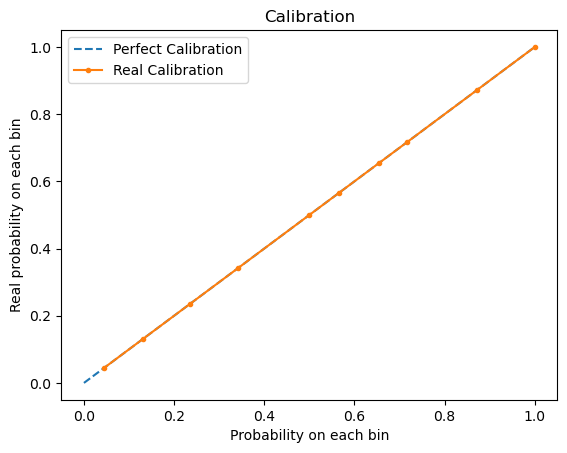

In [38]:
calibration(y_train, y_train_pred_prob)

**Val:**

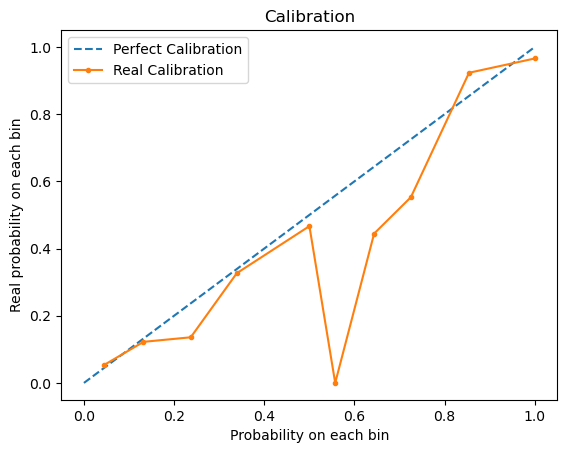

In [39]:
calibration(y_val, y_val_pred_prob)

**Test:**

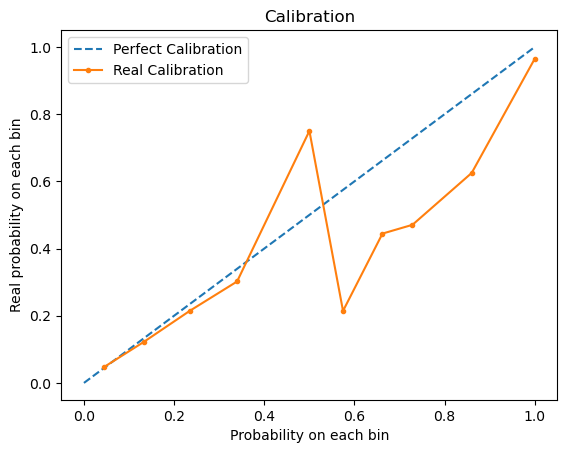

In [40]:
calibration(y_test, y_test_pred_prob)

**Train (Recalibrated):**

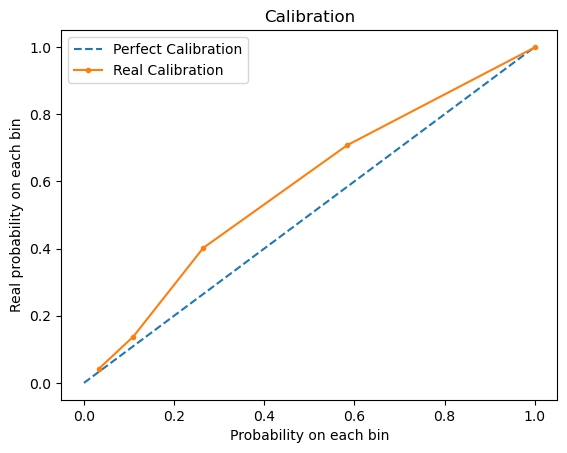

In [41]:
calibration(y_train[f_train], y_train_pred_prob_cal[f_train])

**Val (Recalibrated):**

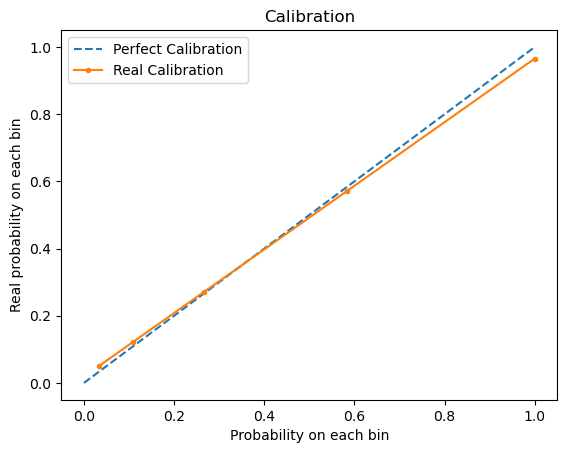

In [42]:
calibration(y_val[f_val], y_val_pred_prob_cal[f_val])

**Test (Recalibrated):**

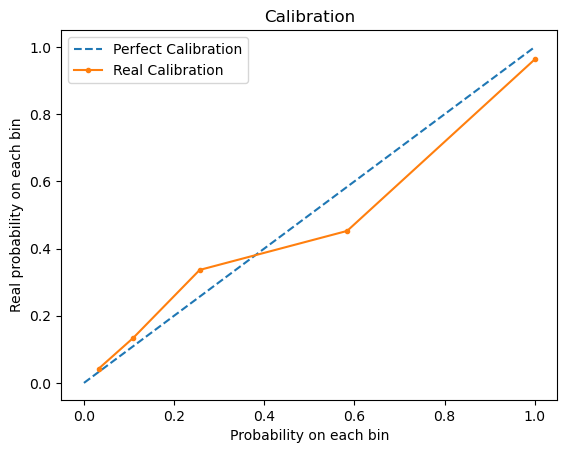

In [43]:
calibration(y_test[f_test], y_test_pred_prob_cal[f_test])

### ix. Confidence Interval

When we have the probabilities $(MP)$ given by a model and the real probabilities $(RP)$ we can define the next random variable:

$ e = RP - MP $

When we have $n$ observations we have:

$ e_i = RP_i - MP_i \ \forall i \in \lbrace 1, ..., n \rbrace $

We can compute $ S $ and $ \bar{e} $ as follows:

$ \bar{e} = \frac{1}{n} \sum_{i=1}^n e_i $

$ S = \sqrt{\cfrac{1}{(n-1)} \cdot \sum_{i=1}^n (e_i - \bar{e})^2} $

Asumming $ e \sim Normal $ we can say that:

$ \bar{e} - S \cdot 1.96 + MP_i \leq RP_i \leq \bar{e} + S \cdot 1.96 + MP_i $     $ \forall i \in \lbrace 1, ..., n \rbrace$  with $ 95 \% $ of confidence.

And also:

$ \bar{e} - \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} \leq \bar{RP} \leq \bar{e} + \cfrac{S}{\sqrt{n}} \cdot 1.96 + \bar{MP} $  with $ 95 \% $ of confidence.

In [44]:
real_probs_test, model_probs_test = calibration_curve(y_test[f_test], y_test_pred_prob_cal[f_test], n_bins = 20, normalize = True)

In [45]:
df_ci_test = pd.DataFrame(zip(model_probs_test, real_probs_test))
df_ci_test = df_ci_test.rename(columns = {0: 'model_prob', 1: 'real_prob'})
df_ci_test['error'] = df_ci_test['real_prob'] - df_ci_test['model_prob']

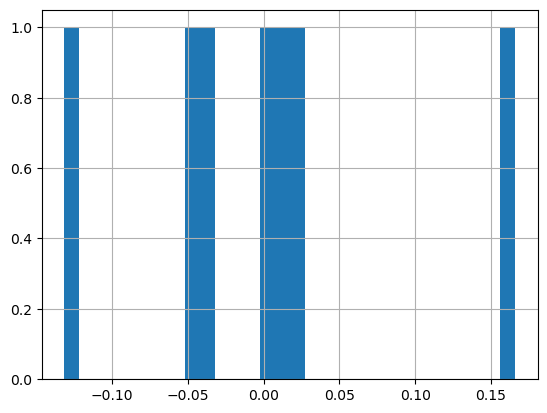

In [46]:
df_ci_test['error'].hist(bins = 30)
plt.show()

**Comments:** The distribution are very similar to a Normal.

In [47]:
bar_e = df_ci_test['error'].mean()
S = df_ci_test['error'].std()

In [48]:
round(bar_e*100, 2), round(S*100, 2)

(-0.13, 9.08)

### x. Patterns

**Loan Grade vs Loan Status**

In [49]:
X_test['predict'] = y_test_pred

In [50]:
round(X_test[X_test['loan_grade_A'] == 1]['predict'].mean()*100, 2)

7.35

In [51]:
round(X_test[X_test['loan_grade_B'] == 1]['predict'].mean()*100, 2)

11.86

In [52]:
round(X_test[X_test['loan_grade_C'] == 1]['predict'].mean()*100, 2)

17.23

In [53]:
round(X_test[X_test['loan_grade_D'] == 1]['predict'].mean()*100, 2)

61.98

In [54]:
round(X_test[X_test['loan_grade_E'] == 1]['predict'].mean()*100, 2)

67.44

In [55]:
round(X_test[X_test['loan_grade_F'] == 1]['predict'].mean()*100, 2)

50.0

In [56]:
round(X_test[X_test['loan_grade_G'] == 1]['predict'].mean()*100, 2)

78.95

In [57]:
X_test = X_test.drop(columns = ['predict'])

### xi. Feature importance

In [58]:
fi = pd.DataFrame(zip(X_train.columns, clf.feature_importances_/sum(clf.feature_importances_)))
fi = fi.rename(columns = {0: 'Variable', 1: 'Importance'})
fi['Importance'] = fi['Importance']*100

fi = fi.sort_values(by = ['Importance'], ascending = False)
fi = fi.reset_index()
fi = fi.drop(columns = ['index'])

In [59]:
fi

,Variable,Importance
0,loan_percent_income,29.737605
1,person_home_ownership,20.036973
2,loan_int_rate,17.029326
3,person_income,10.858967
4,loan_intent,7.933050
5,loan_grade_D,4.018683
6,loan_grade_C,3.892365
7,person_emp_length,3.341959
8,person_age,0.978341
9,loan_amnt,0.674478


### xii. Explainability

In [60]:
import shap

In [61]:
explainer = shap.TreeExplainer(clf)

In [62]:
shap_values = explainer.shap_values(X_test)

In [63]:
df_shap_values = pd.DataFrame(shap_values[1])

In [64]:
df_shap_values.columns = X_test.columns

**Importance Variable**

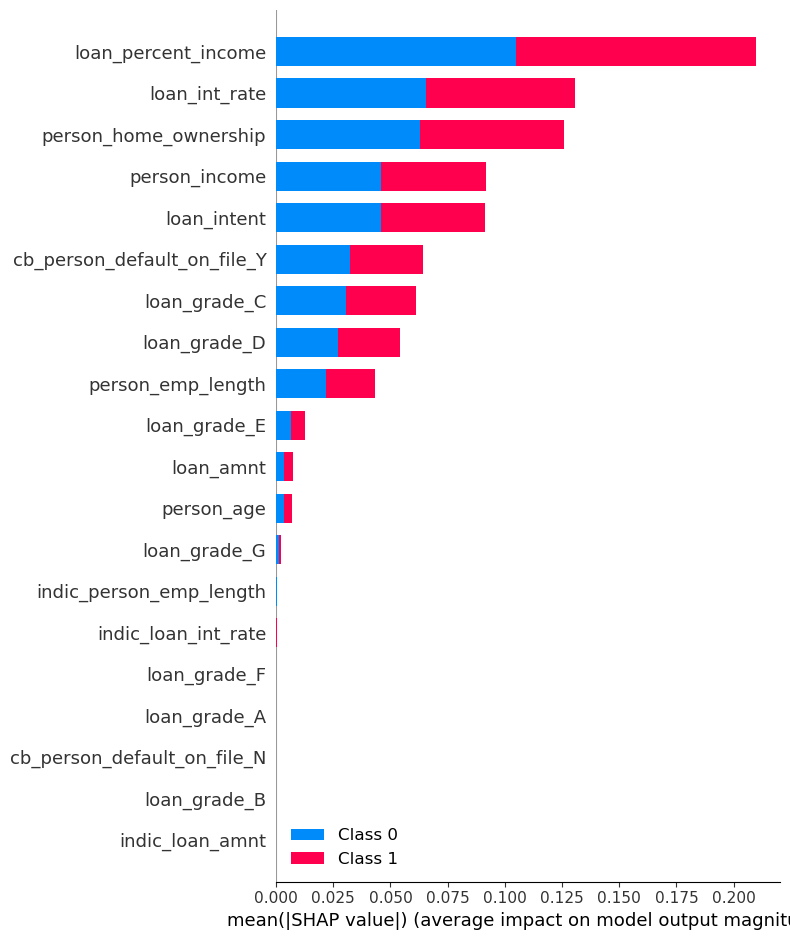

In [65]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [66]:
df_shap_values['partial_sum_SHAP'] = df_shap_values.sum(axis = 1)

In [67]:
df_shap_values = df_shap_values[['partial_sum_SHAP']]

In [68]:
df_shap_values['prob_model'] = y_test_pred_prob

**Sum of SHAP Values**

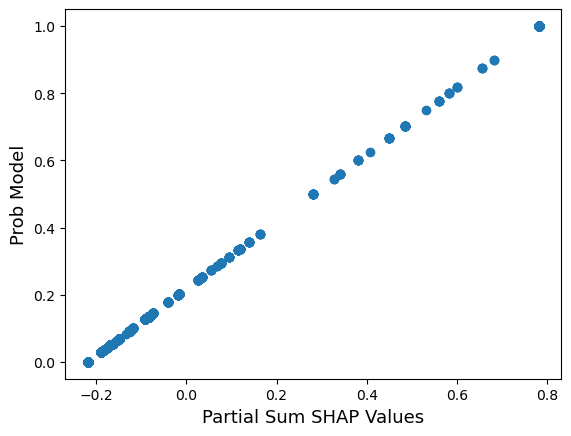

In [69]:
plt.scatter(df_shap_values['partial_sum_SHAP'], df_shap_values['prob_model'])
plt.xlabel('Partial Sum SHAP Values', fontsize = 13)
plt.ylabel('Prob Model', fontsize = 13)
plt.show()

**SHAP dependency**

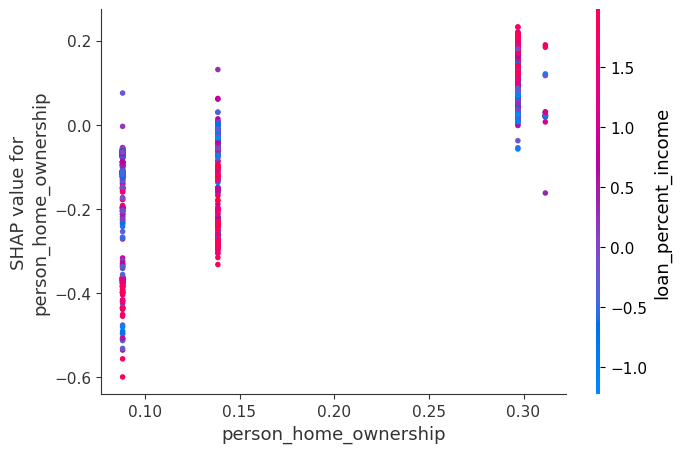

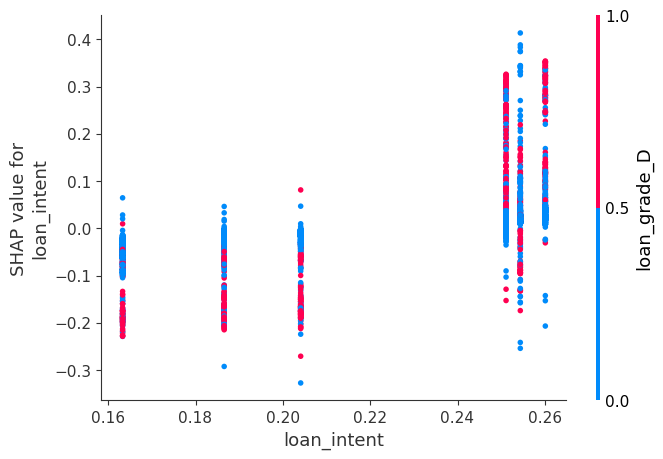

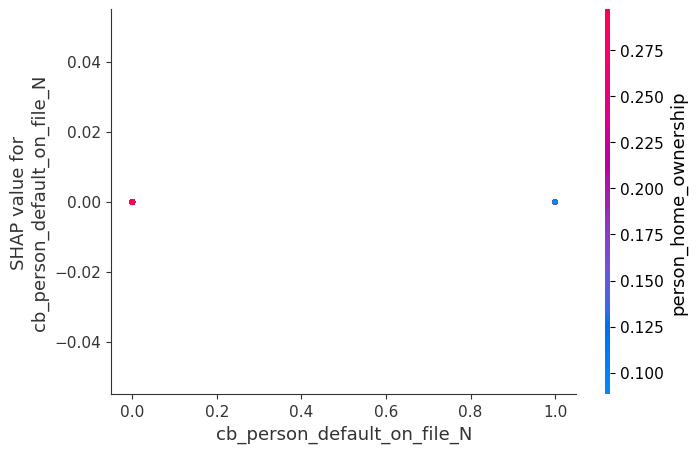

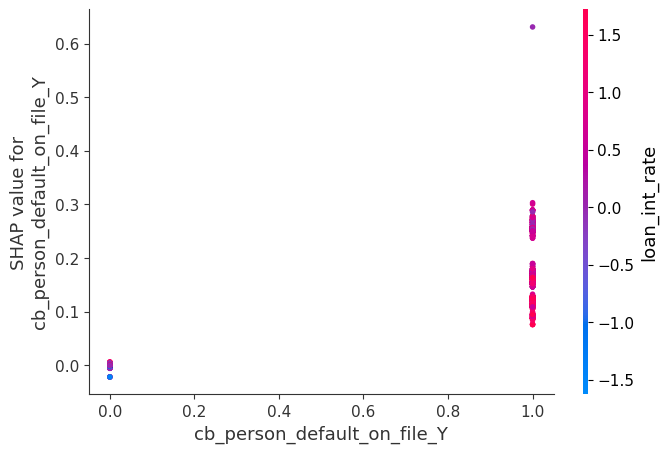

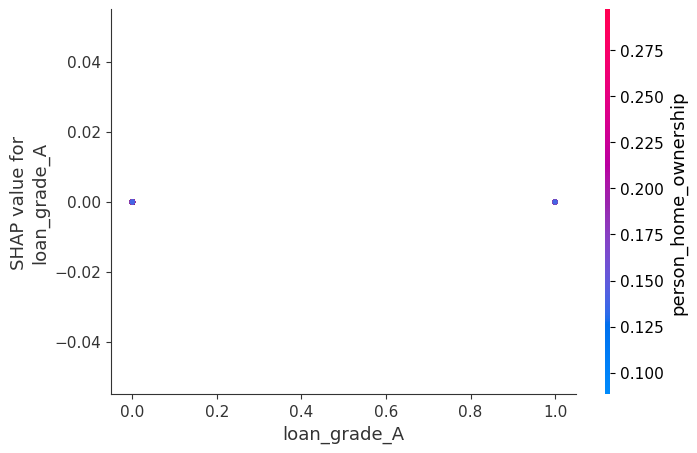

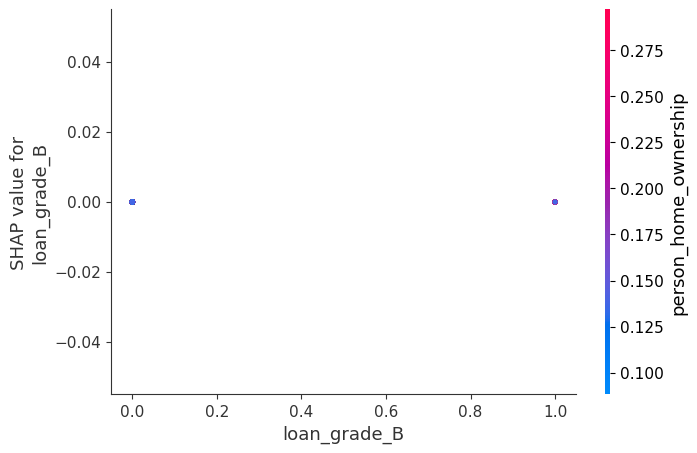

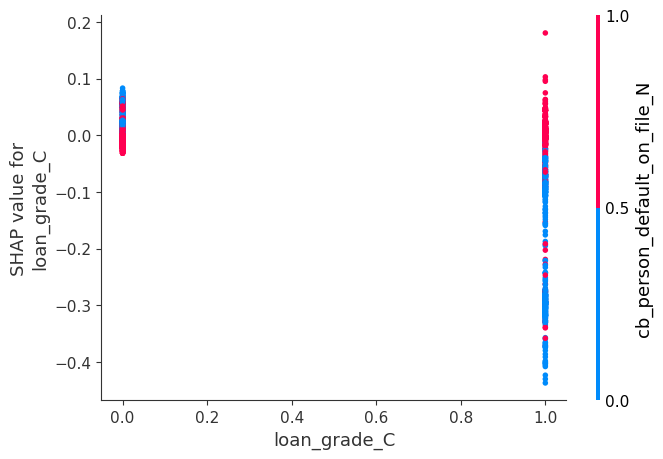

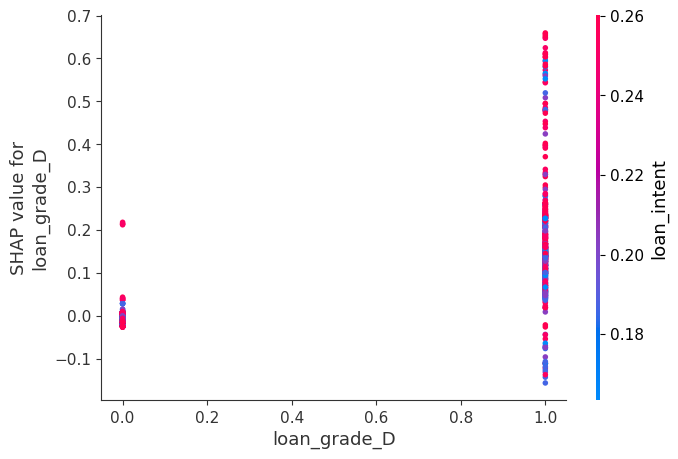

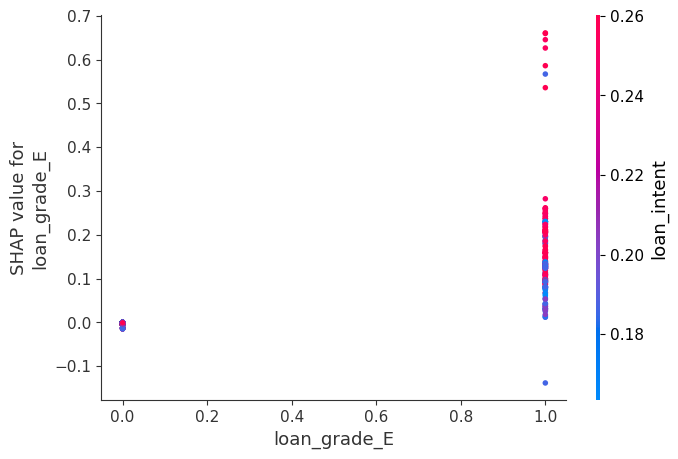

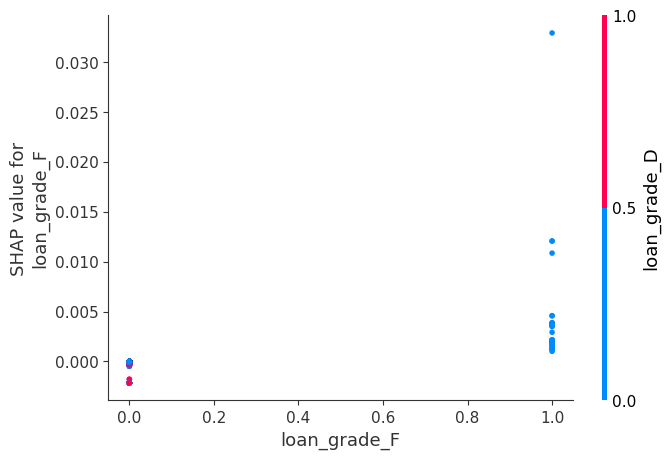

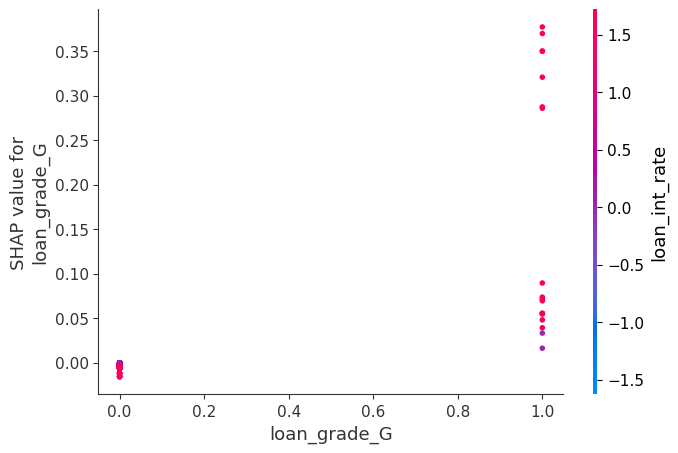

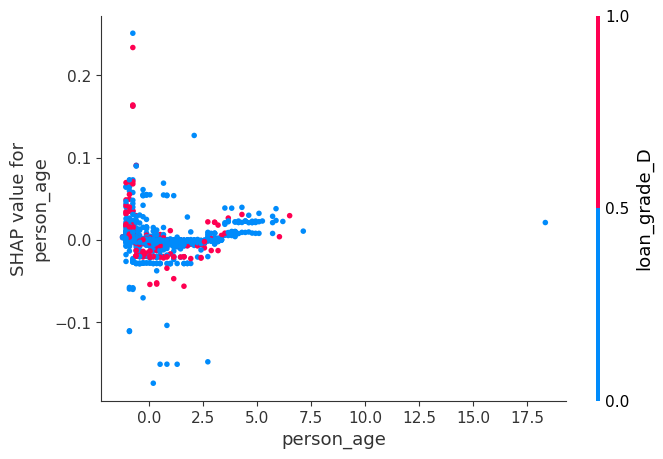

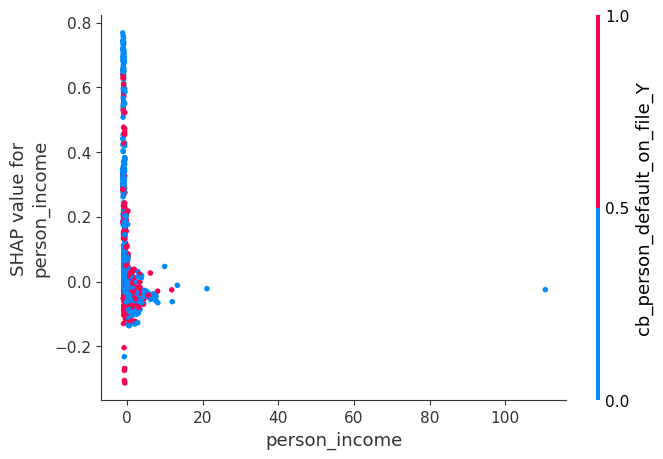

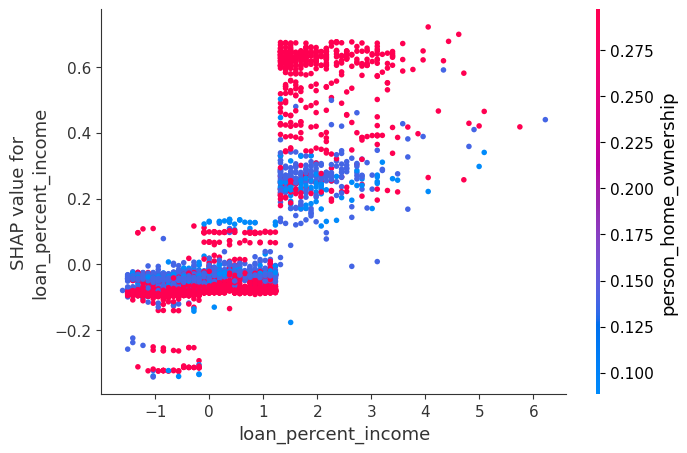

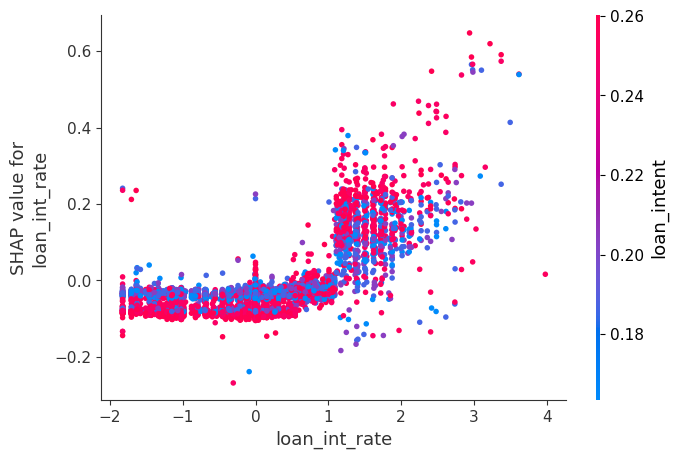

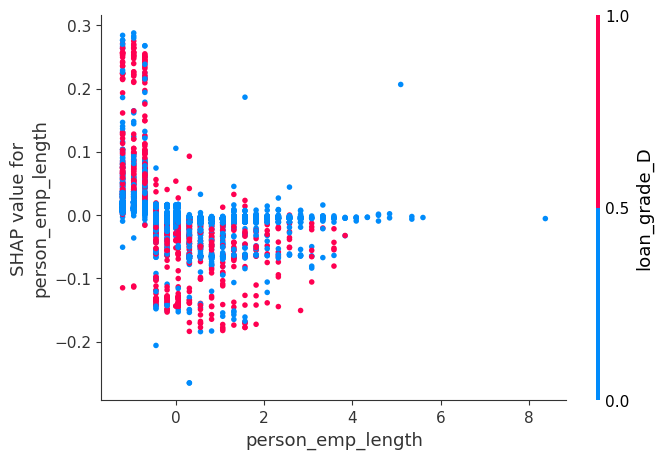

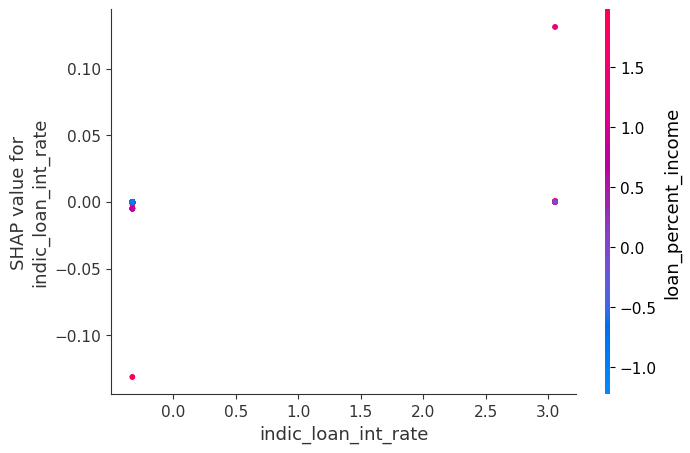

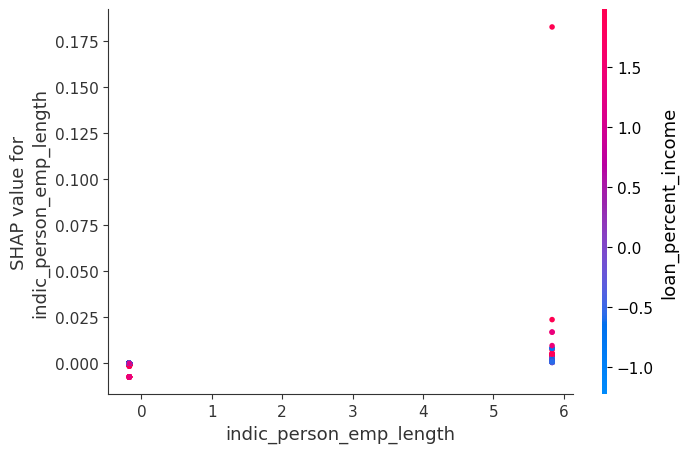

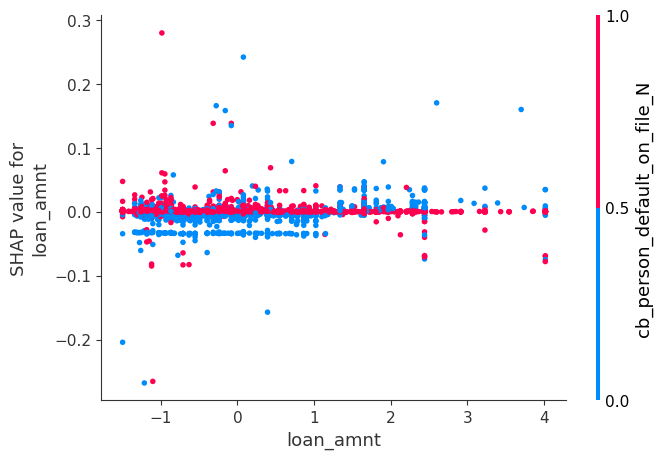

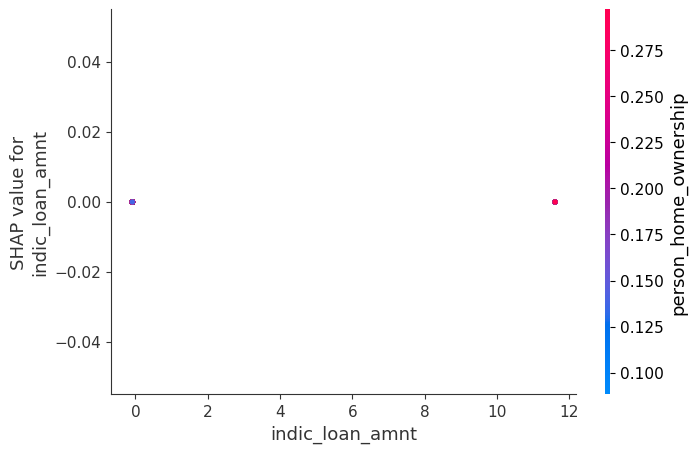

In [70]:
for name in X_test.columns:
    shap.dependence_plot(name, shap_values[1], X_test)

### Time of execution

In [71]:
end = time.time()

In [72]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 0 minutes and 7 seconds.
